In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
initial_data = pd.read_csv('UNSW_NB15_training-set-modified.csv')

In [3]:
initial_data.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   spkts              175341 non-null  int64  
 2   dpkts              175341 non-null  int64  
 3   sbytes             175341 non-null  int64  
 4   dbytes             175341 non-null  int64  
 5   rate               175341 non-null  float64
 6   sttl               175341 non-null  int64  
 7   dttl               175341 non-null  int64  
 8   sload              175341 non-null  float64
 9   dload              175341 non-null  float64
 10  sloss              175341 non-null  int64  
 11  dloss              175341 non-null  int64  
 12  sinpkt             175341 non-null  float64
 13  dinpkt             175341 non-null  float64
 14  sjit               175341 non-null  float64
 15  djit               175341 non-null  float64
 16  sw

In [5]:
initial_data.isnull().sum()

dur                  0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
label                0
dtype: int64

In [6]:
data_to_use = initial_data.dropna()

data_to_use.shape

(175341, 41)

In [7]:
X = data_to_use.drop(axis=1, columns=['attack_cat']) # X is a dataframe
X = X.drop(axis=1, columns=['label'])


y1 = data_to_use['attack_cat'].values # y is an array
y2 = data_to_use['label'].values

In [8]:
def data_ratio(y2):
    '''
    Calculate Y2's ratio
    '''
    unique, count = np.unique(y2, return_counts=True)
    ratio = round(count[0]/count[1], 1)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

The class ratio for the original data: 1.1:1 (2000/1746)


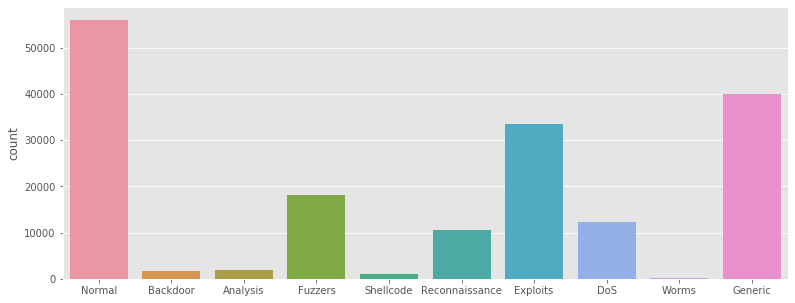

The class ratio for the original data: 0.5:1 (56000/119341)


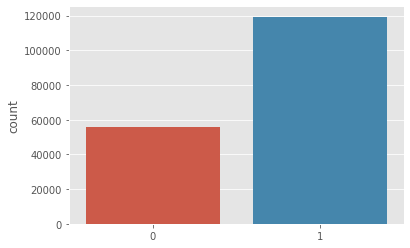

In [9]:
print('The class ratio for the original data:', data_ratio(y1))
plt.figure(figsize=(13,5))
sns.countplot(y1,label="Sum")
plt.show()

print('The class ratio for the original data:', data_ratio(y2))
sns.countplot(y2,label="Sum")
plt.show()

In [10]:
test_data = pd.read_csv('UNSW_NB15_testing-set-modified.csv')
X_test = test_data.drop(axis=1, columns=['attack_cat']) # X_test is a dataframe
X_test = X_test.drop(axis=1, columns=['label'])


y1_test = test_data['attack_cat'].values # y is an array
y2_test = test_data['label'].values

In [11]:
X_train = X
y1_train = y1
y2_train = y2

In [12]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [13]:
numerical_cols

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

In [14]:
categorical_cols

Index([], dtype='object')

In [15]:
t = [('ohe', OneHotEncoder(drop='first'), categorical_cols),
    ('scale', StandardScaler(), numerical_cols)]

col_trans = ColumnTransformer(transformers=t)

col_trans.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('ohe',
                                 OneHotEncoder(categories='auto', drop='first',
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
                                 Index([], dtype='object')),
                                ('scale',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 Index(['dur', 'spkts', 'dpkts', 'sbytes...
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_s

In [16]:
X_train_transform = col_trans.transform(X_train)

In [17]:
X_test_transform = col_trans.transform(X_test)

In [18]:
X_train_transform.shape

(175341, 39)

In [19]:
X_test_transform.shape

(82332, 39)

In [20]:
pd.unique(y1)

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [21]:
pd.unique(y2)

array([0, 1])

In [22]:
target_trans = LabelEncoder()
target_trans.fit(y1_train)

LabelEncoder()

In [23]:
y1_train_transform = target_trans.transform(y1_train)
y1_test_transform = target_trans.transform(y1_test)

In [24]:
y1_train_transform

array([6, 6, 6, ..., 5, 5, 5])

In [25]:
target_trans = LabelEncoder()
target_trans.fit(y2_train)
y2_train_transform = target_trans.transform(y2_train)
y2_test_transform = target_trans.transform(y2_test)

In [26]:
y2_train_transform

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
clf = LogisticRegression(solver='lbfgs', random_state=123, max_iter = 4000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = cross_validate(estimator=clf,
                            X=X_train_transform,
                            y=y2_train_transform,
                            scoring=scoring,
                            cv=cv,
                            return_train_score=False)

In [28]:
cv_results

{'fit_time': array([10.5022018 , 11.32081628, 13.54580331, 14.83567381, 19.40747166]),
 'score_time': array([0.09136558, 0.11129665, 0.13609791, 0.15615487, 0.19053745]),
 'test_accuracy': array([0.92797057, 0.92708452, 0.92728413, 0.9272271 , 0.92748375]),
 'test_precision': array([0.91380046, 0.91187043, 0.9125    , 0.91281277, 0.91386873]),
 'test_recall': array([0.98730571, 0.9883945 , 0.98789174, 0.98738897, 0.98642534]),
 'test_f1': array([0.94913206, 0.94859165, 0.94870041, 0.94863744, 0.94876186]),
 'test_roc_auc': array([0.96948525, 0.96945206, 0.96891897, 0.96798411, 0.96939284])}

In [29]:
cv_results['test_accuracy'].mean()

0.9274100149961656

In [30]:
clf.fit(X=X_train_transform, y=y2_train_transform)


y_pred_class = clf.predict(X=X_test_transform)
y_pred_score = clf.predict_proba(X=X_test_transform)[:, 1]


auc_ontest = roc_auc_score(y_true=y2_test_transform, y_score=y_pred_score)
cm_ontest = confusion_matrix(y_true=y2_test_transform, y_pred=y_pred_class)
precision_ontest = precision_score(y_true=y2_test_transform, y_pred=y_pred_class)
recall_ontest = recall_score(y_true=y2_test_transform, y_pred=y_pred_class)
cls_report_ontest = classification_report(y_true=y2_test_transform, y_pred=y_pred_class)

print('The model scores {:1.5f} ROC AUC on the test set.'.format(auc_ontest))
print('The precision score on the test set: {:1.5f}'.format(precision_ontest))
print('The recall score on the test set: {:1.5f}'.format(recall_ontest))
print('Confusion Matrix:\n', cm_ontest)

print('Classification Report:\n', cls_report_ontest)

The model scores 0.88659 ROC AUC on the test set.
The precision score on the test set: 0.72832
The recall score on the test set: 0.94174
Confusion Matrix:
 [[21075 15925]
 [ 2641 42691]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.57      0.69     37000
           1       0.73      0.94      0.82     45332

    accuracy                           0.77     82332
   macro avg       0.81      0.76      0.76     82332
weighted avg       0.80      0.77      0.76     82332



In [31]:
models = [('LogisticRegression', LogisticRegression(random_state=123, max_iter=5000)),
          ('DecisionTree', DecisionTreeClassifier(random_state=123)),
          ('RandomForest', RandomForestClassifier(random_state=123)),
#           ('GradientBoosting', GradientBoostingClassifier(random_state=123))
#           ('MultiLayerPerceptron', MLPClassifier(random_state=123, solver='adam', max_iter=8000))
         ]

In [32]:
model_names_list = []
cv_fit_time_mean_list = []
cv_accuracy_mean_list = []
cv_precision_mean_list = []
cv_recall_mean_list = []
cv_f1_mean_list = []
cv_roc_auc_mean_list = []

test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_roc_auc_list = []

test_roc_curve_df = pd.DataFrame()

for model_name, clf in models:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(estimator=clf,
                                X=X_train_transform,
                                y=y2_train_transform,
                                scoring=scoring,
                                cv=cv,
                                return_train_score=False)  # prevent to show the train scores on cv splits.

    cv_fit_time_mean = cv_results['fit_time'].mean()
    cv_accuracy_mean = cv_results['test_accuracy'].mean()
    cv_precision_mean = cv_results['test_precision'].mean()
    cv_recall_mean = cv_results['test_recall'].mean()
    cv_f1_mean = cv_results['test_f1'].mean()
    cv_roc_auc_mean = cv_results['test_roc_auc'].mean()

    model_names_list.append(model_name)
    cv_fit_time_mean_list.append(cv_fit_time_mean)
    cv_accuracy_mean_list.append(cv_accuracy_mean)
    cv_precision_mean_list.append(cv_precision_mean)
    cv_recall_mean_list.append(cv_recall_mean)
    cv_f1_mean_list.append(cv_f1_mean)
    cv_roc_auc_mean_list.append(cv_roc_auc_mean)

    clf.fit(X=X_train_transform, y=y2_train_transform)

    y_pred_class = clf.predict(X=X_test_transform)  
    
    y_pred_score = clf.predict_proba(X=X_test_transform)[:, 1]

    accuracy_ontest = accuracy_score(y_true=y2_test_transform, y_pred=y_pred_class)
    
    auc_ontest = roc_auc_score(y_true=y2_test_transform, y_score=y_pred_score)
    
    precision_ontest = precision_score(y_true=y2_test_transform, y_pred=y_pred_class)
    
    recall_ontest = recall_score(y_true=y2_test_transform, y_pred=y_pred_class)
    
    f1_ontest = f1_score(y_true=y2_test_transform, y_pred=y_pred_class)
    
    fpr, tpr, threshold_roc = roc_curve(y_true=y2_test_transform, y_score=y_pred_score)
    
    roc_df = pd.DataFrame(list(zip(fpr, tpr, threshold_roc)),
                          columns=['False Positive Rate', 'True Positive Rate', 'Threshold'])
    
    roc_df['Model'] = '{} (AUC = {:.3f})'.format(model_name, auc_ontest)


    test_accuracy_list.append(accuracy_ontest)
    test_roc_auc_list.append(auc_ontest)
    test_precision_list.append(precision_ontest)
    test_recall_list.append(recall_ontest)
    test_f1_list.append(f1_ontest)
    
    test_roc_curve_df = pd.concat([test_roc_curve_df, roc_df],
                                 ignore_index=True)

In [33]:
results_dict = {'Model Name': model_names_list,
                'CV Fit Time': cv_fit_time_mean_list,
                'CV Accuracy mean': cv_accuracy_mean_list,
                'CV Precision mean': cv_precision_mean_list,
                'CV Recall mean': cv_recall_mean_list,
                'CV F1 mean': cv_f1_mean_list,
                'CV AUC mean': cv_roc_auc_mean_list,
                'Test Accuracy': test_accuracy_list,
                'Test Precision': test_precision_list,
                'Test Recall': test_recall_list,
                'Test F1': test_f1_list,
                'Test AUC': test_roc_auc_list
                }

results_df = pd.DataFrame(results_dict)

results_df.sort_values(by='Test F1', ascending=False)

,Model Name,CV Fit Time,CV Accuracy mean,CV Precision mean,CV Recall mean,CV F1 mean,CV AUC mean,Test Accuracy,Test Precision,Test Recall,Test F1,Test AUC
2,RandomForest,91.839413,0.959736,0.963049,0.978381,0.970654,0.993565,0.870731,0.818020,0.984161,0.893433,0.977035
1,DecisionTree,8.306075,0.948552,0.962916,0.961438,0.962176,0.942744,0.862605,0.823384,0.955396,0.884491,0.854642
0,LogisticRegression,17.177451,0.927410,0.912970,0.987481,0.948765,0.969047,0.774498,0.728317,0.941741,0.821391,0.886591


In [34]:
test_roc_curve_df.head()

,False Positive Rate,True Positive Rate,Threshold,Model
0,0.0,0.000000,2.0,LogisticRegression (AUC = 0.887)
1,0.0,0.000949,1.0,LogisticRegression (AUC = 0.887)
2,0.0,0.001213,1.0,LogisticRegression (AUC = 0.887)
3,0.0,0.001257,1.0,LogisticRegression (AUC = 0.887)
4,0.0,0.001324,1.0,LogisticRegression (AUC = 0.887)


In [35]:
import plotly.express as px
import plotly.graph_objects as go

In [36]:
from sklearn.inspection import plot_partial_dependence

In [37]:
from sklearn.pipeline import Pipeline
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
        
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]

        if isinstance(transformer_in_columns[1], Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        
        try:
            names = transformer.get_feature_names(input_features=raw_col_name)
        
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            
            if transformer_in_columns[1] == "passthrough":
                names = column_transformer._feature_names_in[raw_col_name]
            else:
                names = raw_col_name

        if isinstance(names,np.ndarray): 
            col_name += names.tolist()
        
        elif isinstance(names,pd.Index): 
            col_name += names.tolist()
        
        elif isinstance(names,list):
            col_name += names    

        elif isinstance(names,str):
            col_name.append(names)

    return col_name

In [38]:
new_cols = get_column_names_from_ColumnTransformer(col_trans)

new_cols

['dur',
 'spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'dttl',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'sjit',
 'djit',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'tcprtt',
 'synack',
 'ackdat',
 'smean',
 'dmean',
 'trans_depth',
 'response_body_len',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd',
 'ct_src_ltm',
 'ct_srv_dst',
 'is_sm_ips_ports']

In [39]:
models[2]

('RandomForest',
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=123,
                        verbose=0, warm_start=False))

In [40]:
from sklearn.inspection import permutation_importance

In [41]:
clf_name = models[2][0]
clf = models[2][1]

ct_ftp_cmd           0.000105
is_ftp_login         0.000126
dwin                 0.000343
response_body_len    0.001616
trans_depth          0.001864
ct_flw_http_mthd     0.002009
swin                 0.004106
is_sm_ips_ports      0.005445
ct_src_dport_ltm     0.006330
ct_dst_ltm           0.007154
dtcpb                0.007387
dloss                0.007429
stcpb                0.007625
spkts                0.007902
ct_src_ltm           0.008077
ct_dst_sport_ltm     0.008165
sloss                0.009892
djit                 0.012021
dpkts                0.013169
sjit                 0.013239
ct_srv_src           0.019862
dbytes               0.019997
synack               0.022770
ackdat               0.022878
ct_dst_src_ltm       0.023428
sinpkt               0.024716
smean                0.027958
dur                  0.029539
ct_srv_dst           0.030825
tcprtt               0.031332
sbytes               0.033168
dmean                0.038563
sload                0.039895
dttl      

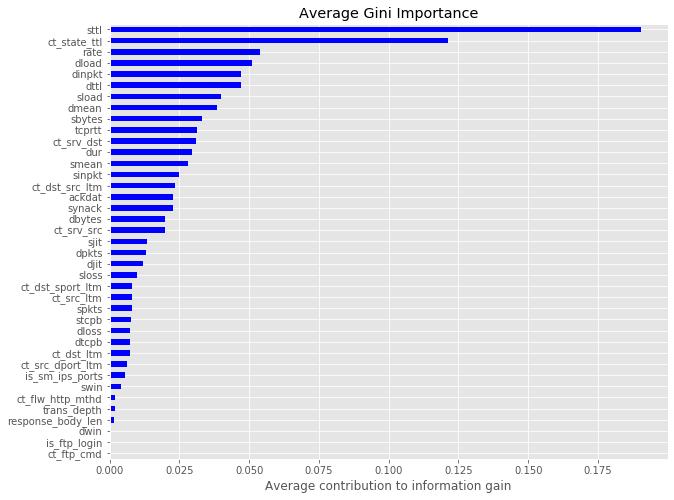

In [42]:
# Plot the feature importance
feat_scores = pd.Series(clf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');
print(feat_scores)

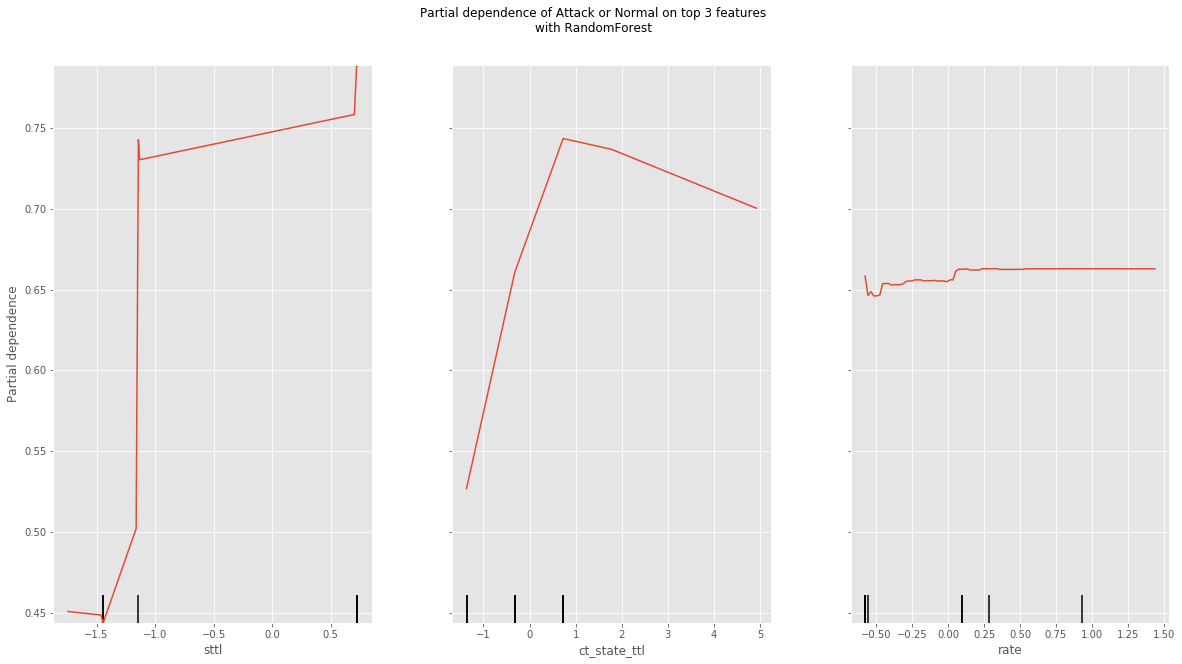

In [43]:
clf_name = models[2][0] # the classifier name
clf = models[2][1] # the classifier itself

features = [6,28,5]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack or Normal on top 3 features\n"
              "with {}".format(clf_name))
fig.set_size_inches(20, 10)
fig.subplots_adjust(hspace=.4, wspace=.25, top=.9)


         Current function value: 0.180155
         Iterations: 35


/home/jokera/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/jokera/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home/jokera/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jokera/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jokera/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               175341
Model:                          Logit   Df Residuals:                   175306
Method:                           MLE   Df Model:                           34
Date:                Sat, 06 Jun 2020   Pseudo R-squ.:                  0.7124
Time:                        16:31:57   Log-Likelihood:                -31589.
converged:                      False   LL-Null:                   -1.0983e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.0590      0.072    -28.619      0.000      -2.200      -1.918
dur                   0.0359      0.003     11.694      0.000       0.030       0.042
spkts                -0.

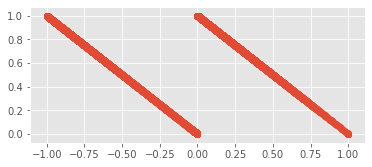

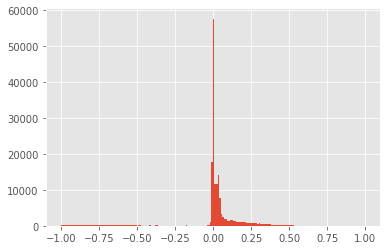

In [44]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import exp

# df = pd.concat([pd.Series(X_train.all()), pd.Series(y2_train.all())])
# print(df)

logreg = smf.logit(formula='label ~ dur+spkts+dpkts+sbytes+dbytes+rate+sttl+dttl+sload+dload+sloss+dloss+sinpkt+dinpkt+sjit+djit+swin+stcpb+dtcpb+dwin+tcprtt+synack+ackdat+smean+dmean+trans_depth+response_body_len+ct_srv_src+ct_state_ttl+ct_dst_ltm+ct_src_dport_ltm+ct_dst_sport_ltm+ct_dst_src_ltm+is_ftp_login+ct_ftp_cmd+ct_flw_http_mthd+ct_src_ltm+ct_srv_dst+is_sm_ips_ports', data=data_to_use).fit()
print(logreg.summary())

arr = []
for i in logreg.fittedvalues:
    arr.append(exp(i)/(1+exp(i)))
pred_val = arr
# true_val = y2_train.values.copy()
true_val = y2_train.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(residual, pred_val)
plt.show()
plt.hist(residual, bins=200)
plt.show()